# Face Recognition Project

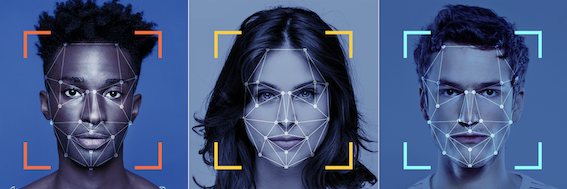

In this project you'll dive into face recognition framework and train neural network for face recognition task, play with losses and metrics.

This basic notebook will give you 8/10 points, if completed fully. There are also additional features you might implement to get additional points. You may do additional tasks and receive additional points even if you didn't fully complete the basic notebook. This means you can choose which tasks to do. **Additional features that you might implement are listed in Telegram chat**.

We will train neural network on [CelebA dataset](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). 

As you see on the site, images of celebA dataset look like this:


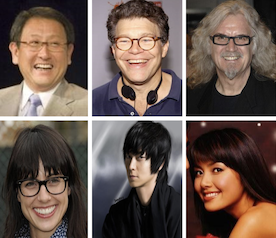

But we won't train a neural network for face recognition on those images. We'll need to preprocess them first. Let's see why we need it and how we need to preprocess them.

Let's look at how face recognition systems work:

## Face recognition model training and inference setup

This section describes how face recognition models are trained, what data alignment is and how the inference of face recognition model looks like. If you are familiar with this, you can skip this section.

### Model training

To train face recognition model on any facial dataset images must be aligned first. This step is very important to achieve a good quality of face recognition.

What is alignment: it consists of three steps:
1. Given image, identify facial landmarks on the image (coordinates of eyes, nose and mouth points). Separate neural network can be used there which was trained to identify landmarks on facial images. You can refer to [PyTorch Landmarks tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) to see how this works.
2. Rotate all the images in the dataset so that eyes of the person on every image lie on a certain pre-defined horizontal line.
3. Scale all the images in the dataset so that the size of the faces are approximately identical.

Here's an example of what we would get after alignment of all the images of Aaron Peirsol from our dataset:

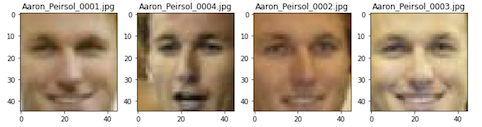

You see that eyes of all the faces lie on one horizontal line and all the faces have almost the same size. If we align all the images in the dataset, we can then train a neural network on aligned images.

**Why we need the alignment procedure**: the alignment of all faces in dataset makes the task of facial recognition easier for the model. If all the faces that model sees are of the same size and have their landmarks (eyes, nose, etc) on almost the same parts of the images, it is easier for the model to learn to identify a person on the image. The model diesn't need to "search" for the face and eyes positions on the image befire performing a recognition.

If you are interested, you can also train a model on non-aligned images, but you'll see that it would perform badly. It is possible though to train a model for face recognition without pre-alignment of all the faces, but this would require a huge amount of data — more that almost any company has. The only company that has openly presented its face recognition system that does not require special alignment is Facebook — their neural network was trained on a really huge amount of data using a special trick to avoid alignment. You can read more details [here](https://research.fb.com/publications/deepface-closing-the-gap-to-human-level-performance-in-face-verification/)

### Model inference

So let's see how the model trained on aligned faces can be used in real world:

Let's assume you owe a company and you want to build a face recognition system for your working office. You decided to hang some cameras around the office and want them to be able to recognize faces of all your employees when they are sitting / walking around the office (we let you decide by yourself why you would need such a system in your office)


A system for face recognition typically conststs of 3 stages:
- face detection
- face alignment
- face recognition

Let's discuss them in detail:

**Face detection**

When the camera is hanged on the wall it records a video and splits the video into single images, like this:

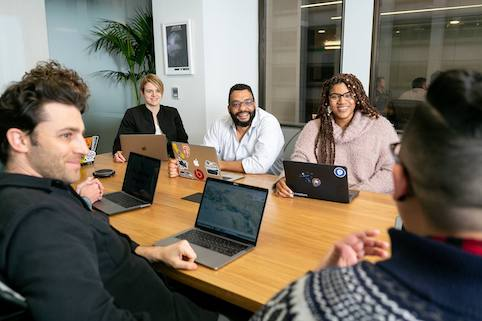

To be able to recognize all the faces on the photo you need first to detect all the faces that are present on the photo, like this:

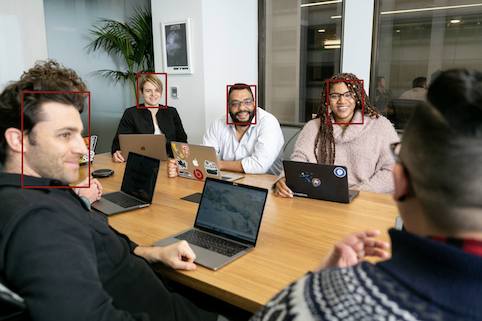

That is the first part — detection. You could use any neural network that can detect humans for this.

**Face alignment**

The second stage is to align all the faces found. The alignment procedure here should be the same as used to align training images.

So we'll get an image of a guy on a photo aligned like this:

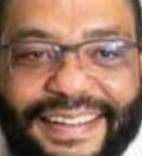

**Face recognition**

On the third stage we use the neural network that we trained to recognize a face.

So that's how the face recognition models pipeline work. You can also read about it more on [this link](https://www.nytimes.com/wirecutter/blog/how-facial-recognition-works/) (and using internet search)

## Neural network model architecture 

Let's discuss how model for face recognition should look like.



The easiest and, actually, the most used way to build a neural network for face recognition is to build it as a **simple classifier**.

Assume we have a dataset with photos of N different people. Then we can build a neural network to classify all the images from the dataset into N classes. Each class refers to one unique person in the dataset.

**How do we recognize new people by this network then?** We actually want the network for face recognition to be able to recognize not only the people which are in training set, but almost every person in the world.

That is how: after training the model, we'll drop it's last classification layer. After that when we'll pass an image of the person through network, we'll get the output of the pre-last layer — it's **the embedding of the image**. Having embeddings of two different images we can compare them using **cosine distance**. The less the distance is — the higher the probability that those two photos belong to one person is. 

Using that technique we can get embeddings of every image — even of unseen people, compare them, and reveal images belonging to same people. 

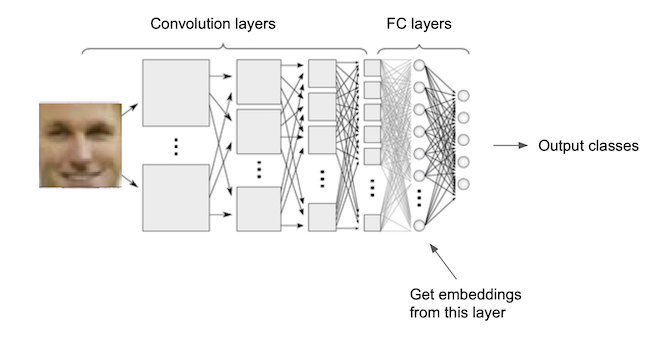

## Task 1 (2 points): build a neural network for faces classification as discribed above.

### Dataset 

We will train out face recognition network on part of the [CelebA dataset](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). But we'll use a version of it that has all the images in it aligned and cropped. You can download the dataset using this link: https://disk.yandex.ru/d/S8f03spLIA1wrw or using the code below:

In [1]:
! pip install wldhx.yadisk-direct
! curl -L $(yadisk-direct https://disk.yandex.ru/d/S8f03spLIA1wrw) -o celebA_train.zip
! unzip -qq celebA_train.zip

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  162M  100  162M    0     0  17.9M      0  0:00:09  0:00:09 --:--:-- 19.6M


Let's look at the data first:

In [2]:
! ls celebA_train_500/

celebA_anno.txt  celebA_imgs  celebA_train_split.txt


- celebA_imgs — folder with aligned images 
- celebA_anno.txt — file with annotations: which person each image corresponds to
- celebA_train_split.txt — file with train/val/test info

In [1]:
# Поключение необходимых пакетов


from torchinfo import summary
import timm
import os
import cv2
from tqdm import tqdm
import numpy as np
import seaborn as sns
import pandas as pd
from PIL import Image
from skimage import io, transform
import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset
import torchvision.transforms as T
import torchvision.transforms.functional as F
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import make_axes_locatable
import torchvision.transforms.functional as F
from IPython.display import clear_output
from pytorch_metric_learning.losses import ArcFaceLoss


/home/akustov/anaconda3/envs/my_work/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


Let's visualize some images to understand what we're dealing with:

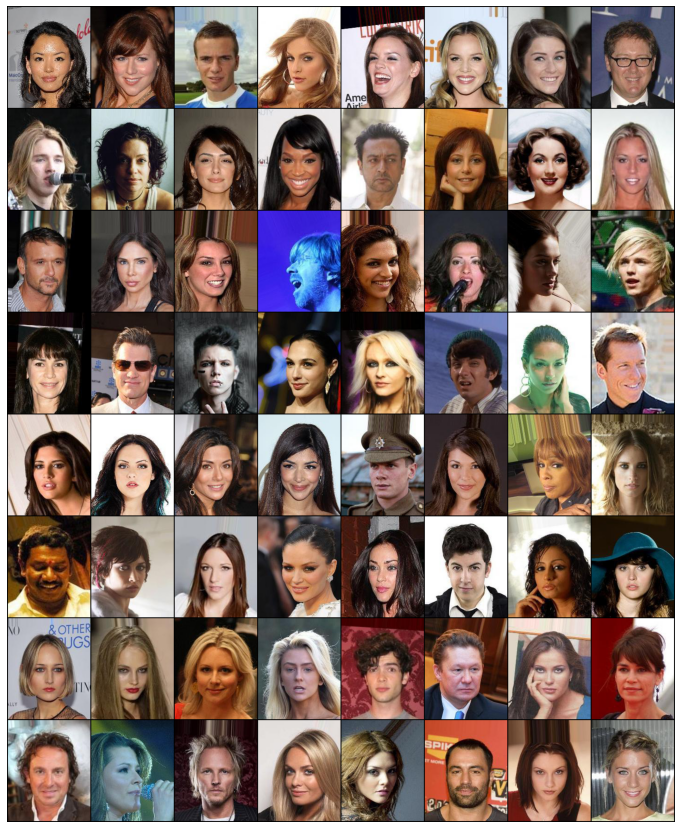

In [2]:
# Вызуализация картинов

def show_imgs(images_folder, count):
    '''
    Перемешиваем файлы, загружаем, как PIL, конвертируем в тензоры, затем визуализируем
    '''
    
    
    convert_tensor = T.ToTensor()
    images_names = np.random.permutation(np.array(os.listdir(images_folder)))[:count]
    imgs = []
    for img in images_names:
        img = Image.open(os.path.join(images_folder, img))
        img = convert_tensor(img)
        imgs.append(img)
    imgs = torch.stack(imgs, 0)
    imgs = make_grid(imgs).permute(1,2,0)
    plt.figure(figsize = (15, 15))
    plt.imshow(imgs)
    plt.axis('off')
    plt.show()
    del imgs

images_folder = './celebA_train_500/celebA_imgs/'
show_imgs(images_folder, 64)

In [3]:
#  Разметка картинок по person
df_person_lables = pd.read_csv("./celebA_train_500/celebA_anno.txt", sep = ' ', header = None)
df_person_lables.columns = ['image_name', 'person']
print(len(df_person_lables))
df_person_lables.head()

12011


image_name  person
0  000001.jpg       0
1  000404.jpg       0
2  003415.jpg       0
3  004390.jpg       0
4  018062.jpg       0

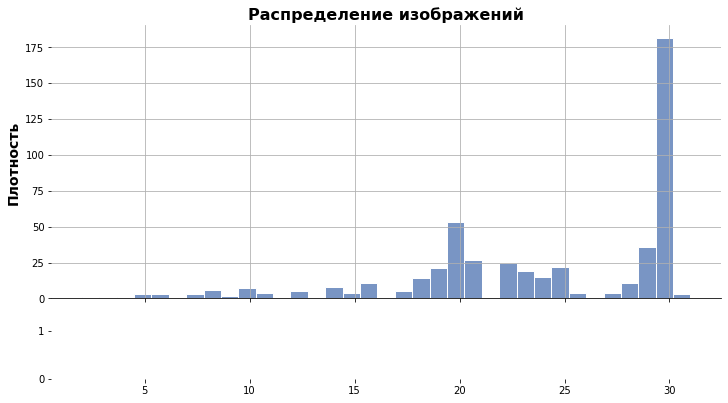

Число изображений для одного человека
min                                   2.000
mean                                 24.022
max                                  31.000

In [4]:
# Построим гистограмму

images_per_person = df_person_lables.groupby('person', as_index = False)['image_name'].count().rename(columns = {"image_name" : "image_count"}).sort_values("image_count", ascending = False)

images_per_person['person'] = images_per_person['person'].astype(str)

fig, (ax_hist, ax_box) = plt.subplots(2, figsize = (12,6.5), sharex = True, gridspec_kw = {"height_ratios": (.85, .15)})
sns.set(style = 'ticks', font_scale = 1.4)
sns.set_color_codes('muted')

sns.histplot(images_per_person['image_count'], ax = ax_hist, kde = False, bins = 35)

ax_hist.set_ylabel("Плотность", fontweight = 'bold', fontsize = 14)
ax_hist.set_title("Распределение изображений", fontweight = 'bold', fontsize = 16)
ax_hist.grid()
sns.despine(ax = ax_box, left = True, bottom = True)
sns.despine(ax = ax_hist, left = True)
plt.show()

images_per_person.describe().loc[['min','mean','max']].rename(columns = {'image_count' : 'Число изображений для одного человека'})


## Image preprocessing

In [5]:
class CustomCrop(object):
    '''
    Функция, которая обезает картинку и смещает центр

    Input:
        image (tensor): исходное изображение (CHW)
    Parameters:
        crop_size (tuple): Выходная размерность тензора
        adjust_center_x (int) : Сдвиг по оси Х
        adjust_center_y (int) : Сдвиг по оси Y
    Return:
        image (tensor): Отредактированное изображение (CHW)
    '''
    def __init__(self, crop_size, adjust_center_x = 10, adjust_center_y = 10):
        self.new_h, self.new_w = crop_size
        self.adjust_center_x = adjust_center_x
        self.adjust_center_y = adjust_center_y

    def __call__(self, image):

        _, h, w = image.shape

        cx = w // 2 - self.adjust_center_x
        cy = h // 2 - self.adjust_center_y

        lower = cy - (self.new_h // 2)
        upper = cy + (self.new_h // 2)
        left = cx - (self.new_w // 2)
        right = cx + (self.new_w // 2)

        return image[..., lower : upper, left : right]

In [6]:
source = './celebA_train_500/celebA_imgs/'
destination = './celebA_train_500/celebA_prep'

tmfs = T.Compose([
    T.ToTensor(),
    T.Resize(340),
    CustomCrop((224, 200), 0, -30)
])

def preprocessing(source, destination, tmfs):
    os.makedirs(destination, exist_ok = True)
    imgs = os.listdir(source)
    source_paths = [os.path.join(source, x) for x in imgs]
    dest_paths = [os.path.join(destination, x) for x in imgs]
    for idx, path in enumerate(tqdm(source_paths)):
        img = Image.open(path)
        img = tmfs(img)
        save_image(img, dest_paths[idx])
    print("Готово. Обработано {} изображений". format(len(os.listdir(destination))))

preprocessing(source, destination, tmfs)

100%|█████████████████████████████████████| 23948/23948 [09:37<00:00, 41.49it/s]


Готово. Обработано 23948 изображений


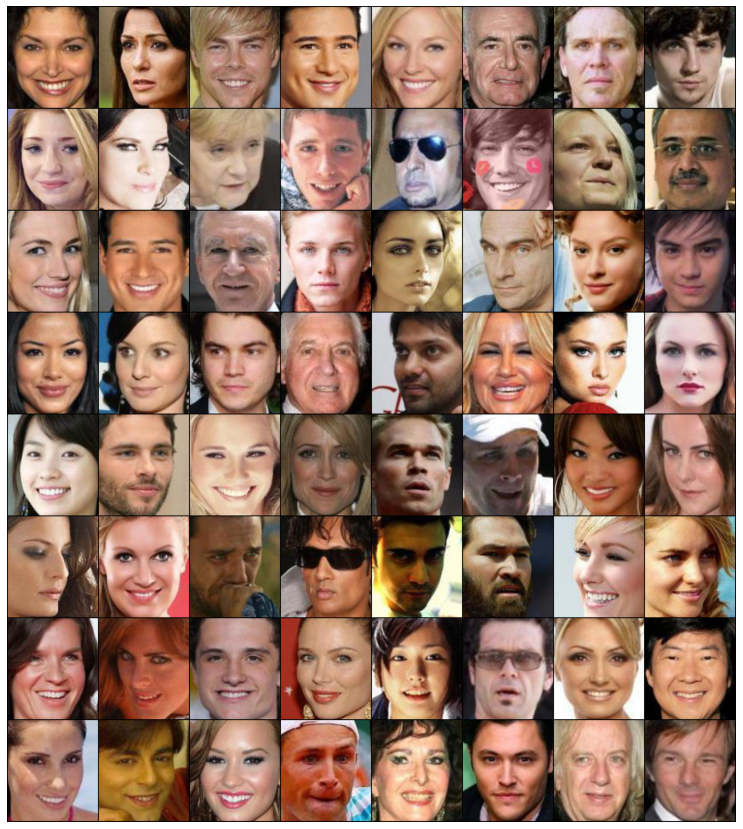

In [7]:
show_imgs(destination, 64)

### Train Neural Network

Let's build a Datasets and network using this images:

In [8]:
def tensorboard(result, max_epochs):
    '''
    Визуализация функции потерь и точности во время обучения
    '''
    
    tr_loss, val_loss, tr_acc, val_acc = [*result.values()]
    fig, axs = plt.subplots(1,2, figsize = (16.5, 5.5))
    sns.set(style = 'ticks', font_scale = 1.4)
    axs[0].plot(tr_loss, label = 'Train', lw = 2.6, c = '#114866', ls = 'dashed')
    axs[0].plot(val_loss, label = 'Validation', lw = 2.6, c = '#8c0755')
    axs[0].scatter(0, tr_loss[0], s = 15,  c = '#114866')
    axs[0].scatter(0, val_loss[0], s = 15, c = '#8c0755')
    axs[1].plot(tr_acc, lw = 2.6, c = '#114866', ls = 'dashed')
    axs[1].plot(val_acc, lw = 2.6, c = '#8c0755')
    axs[1].scatter(0, tr_acc[0], s = 15,  c = '#114866')
    axs[1].scatter(0, val_acc[0], s = 15, c = '#8c0755')
    
    # constraint axis
    max_loss = np.max([tr_loss, val_loss])
    axs[0].set_ylim(-0.025, max_loss + max_loss / 10)
    axs[0].set_xlim(-0.25, max_epochs + 0.25)
    axs[1].set_ylim(-0.025, 1.025)
    axs[1].set_xlim(-0.25, max_epochs + 0.25)

    axs[1].axhline(y = 0.7, xmin = -0.5, xmax = max_epochs + 0.5, ls = '--', color = 'gray', lw = 2)
    axs[1].text(x = max_epochs - max_epochs / 10, y = 0.725, s = 'минимум годноты', fontstyle = 'italic', color = 'gray', fontsize = 12)

    baseline = np.argmax(np.where(np.array(val_acc) > 0.7, np.array(val_acc), 0))
    if baseline != 0:
        axs[1].scatter(baseline, np.array(val_acc)[baseline] + 0.04, s = 50, c = '#8c0755', zorder = 10, marker = 'v')

    titles = ['Loss', 'Accuracy']
    for i, ax in enumerate(axs.flatten()):
        ax.set(xlabel = 'Epoch')
        ax.grid(lw = 2, ls = 'dotted')
        ax.set_facecolor('#f5f5f5')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("top", size="12%", pad=0)
        cax.get_xaxis().set_visible(False)
        cax.get_yaxis().set_visible(False)
        cax.set_facecolor('#a6a6a6')
        
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(1.5)
            cax.spines[axis].set_linewidth(1.5)
        
        at = AnchoredText(
            titles[i], loc=10,
            prop=dict(backgroundcolor='#a6a6a6',
                      size=16, 
                      weight = 'bold', 
                      color='white'), 
            frameon = False)
        cax.add_artist(at)
    fig.legend(bbox_to_anchor = (0.5, 0.0265, 0.1125, 0.0975), ncol = 2, fancybox = False, edgecolor = 'black', borderpad = 0.75)
    plt.tight_layout()
    plt.show()

In [9]:
def get_paths(root, dataset_type='train'):
    '''
    a function that returnes list of images paths for a given type of the dataset
    params:
      dataset_type: one of 'train', 'val', 'test'
    '''

    labels_dict = {
        'train': 0,
        'val': 1,
        'test': 2}

    f = open('celebA_train_500/celebA_train_split.txt', 'r')
    lines = f.readlines()
    f.close()

    lines = [x.strip().split() for x in lines]
    lines = [x[0] for x in lines if int(x[1]) == labels_dict[dataset_type]]

    images_paths = []
    for filename in lines:            
        images_paths.append(os.path.join(root, filename))
    
    return np.array(images_paths)


class celebADataset(Dataset):
    '''
    Feel free to rewrite it. For ex. cache all images in RAM 
    to increase training speed
       
    '''
    
    
    def __init__(self, dataset_type, transform, aug=None):
        root = 'celebA_train_500/celebA_prep/'
        self.mode = dataset_type
        self.images = get_paths(root, 
                                dataset_type=dataset_type)

        f = open('celebA_train_500/celebA_anno.txt', 'r')
        labels = f.readlines()
        f.close()
        labels = [x.strip().split() for x in labels]
        labels = {x:y for x, y in labels}
        self.labels = [int(labels[x.split('/')[-1]]) for x in self.images]

        self.transform = transform
        self.aug = aug
    
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx): 
        
        img_name = self.images[idx]
        label = self.labels[idx]
        
        image = Image.open(img_name)

        sample = {
                'image': image,
                'label': label}

        if (self.aug) and (self.mode == 'train'):
            sample['image'] = self.aug(sample['image']) # Train augmentation
        else:
            sample['image'] = self.transform(sample['image']) # Valid tranformation

        return sample

In [10]:
# Предпроцессинг
transform = T.Compose([
        T.ToTensor(),
        T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Аугментация
aug = T.Compose([
        T.ToTensor(),
        T.RandomHorizontalFlip(0.5),
        T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


train_data = celebADataset('train', transform, aug)
val_data = celebADataset('val', transform, None)
test_data = celebADataset('test', transform, None)


batch_size = 128
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers = 15, pin_memory = True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers = 15, pin_memory = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers = 15, pin_memory = True)

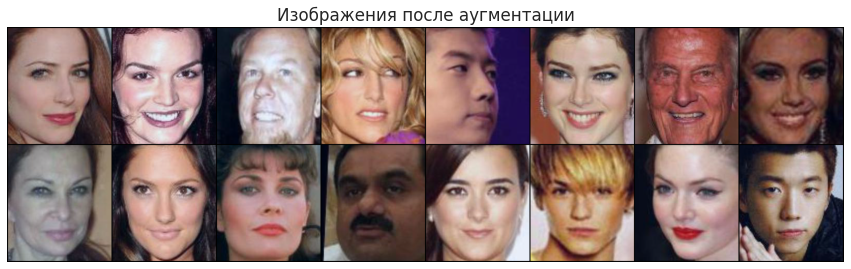

In [11]:
example = next(iter(train_loader))['image'][:16]

grid = make_grid(example, normalize = True)
plt.figure(figsize = (15, 10))
plt.imshow(grid.permute(1,2,0))
plt.axis('off')
plt.title("Изображения после аугментации")
plt.show()

del grid, example

**Workflow**: train a model on train_data using val_data for validation.Use standard CE loss.  Calculate the loss and accuracy on test set after training. 

You may use whatever model you want, including pre-trained on ImageNet models from torchvision. Please note, that **it is not allowed to use pre-trained models on any other dataset except ImageNet**. 

To get higher score, try to adjust hyperparameters, maybe try augmentations, etc. 

Hints: Do not use too big model. Small ResNet-like network is enough to get the required score. Use at least 2 linear layers on the bottom. You'll need to drop the last layer after training and get image embeddings from the pre-last layer. It's not required to get the embedding from linear layer though: you may get it from last convolution layer, if you want.

**To get the whole mark for this section you need to achieve 70% accuracy on test set**.

In [12]:
device = 'cuda:1'
device

'cuda:1'

In [13]:
import gc

def clear_memory():
    gc.collect()
    torch.cuda.empty_cache()
    
def create_checkpoint(model, optimizer, epoch, name = 'inception-resnet-v2'):
    os.makedirs('./state', exist_ok = True)
    torch.save({
        'model' : model.state_dict(),
        'optimizer' : optimizer.state_dict()
    }, '{}-e{}.weights'.format(name, epoch))

In [18]:
def fit(model, tr_loader, val_loader, optimizer, criterion, n_epochs, sched = None, return_results = False):

    history = dict()
    history['train_loss'] = []
    history['val_loss'] = []
    history['train_accuracy'] = []
    history['val_accuracy'] = []

    for epoch in range(1, n_epochs + 1):
        # удаление кэша
        clear_memory()

        # Обучение
        model.train()
        epoch_tr_loss = 0
        epoch_tr_correct = 0
        for batch in tqdm(tr_loader, desc = 'Процесс обучения'):
            batch_x, batch_y = batch['image'].to(device), batch['label'].to(device)
            optimizer.zero_grad()

            output = model.forward(batch_x)
            loss = criterion(output, batch_y)

            loss.backward()
            optimizer.step()

            epoch_tr_loss += loss.item()
            epoch_tr_correct += (output.argmax(1) == batch_y).sum().item()

        # Инференс
        model.eval()
        epoch_val_loss = 0
        epoch_val_correct = 0
        for batch in val_loader:
            batch_x, batch_y = batch['image'].to(device), batch['label'].to(device)
            with torch.no_grad():
                output = model.forward(batch_x)
                val_loss = criterion(output, batch_y)
                epoch_val_loss += val_loss.item()
                epoch_val_correct += (output.argmax(1) == batch_y).sum().item()

        # Логирование 
        history['train_loss'].append(epoch_tr_loss / len(tr_loader))
        history['val_loss'].append(epoch_val_loss / len(val_loader))
        history['train_accuracy'].append(epoch_tr_correct / len(tr_loader.dataset))
        history['val_accuracy'].append(epoch_val_correct / len(val_loader.dataset))
        
        # Scheduler
        if sched is not None:
            sched.step(history['val_loss'][-1])
        
        # Визуализация
        clear_output(wait = True)
        tensorboard(history, n_epochs)
    
        # Сохранение чекпоинта
        create_checkpoint(model, optimizer, epoch, name = 'inception-resnet-v2_ce')
    
    if return_results:
        return history

In [15]:
embedding_size = 512

In [19]:
# Будем использовать inception_resnet_v2

inception_resnet_v2 = timm.create_model('inception_resnet_v2', pretrained=True, num_classes=0)
inception_resnet_v2.classif = nn.Sequential(
    nn.Linear(1536, embedding_size), 
    nn.BatchNorm1d(embedding_size),
    nn.ReLU(inplace = True),
)

inception_resnet_v2.logits = nn.Sequential(
    nn.Linear(embedding_size, embedding_size),
    nn.ReLU(inplace = True),
    nn.Linear(embedding_size, 500)
)

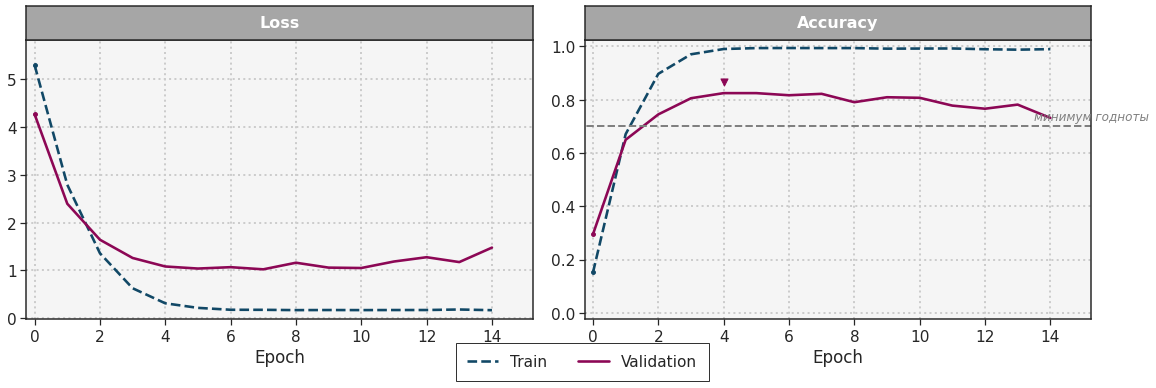

In [20]:
inception_resnet_v2.to(device)
optimizer = torch.optim.Adam(inception_resnet_v2.parameters(), lr = 1e-3)
criterion = nn.CrossEntropyLoss()
n_epochs = 15

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)

fit(inception_resnet_v2, train_loader, val_loader, optimizer, criterion, n_epochs, sched = scheduler)

Code for model evaluating (you can modify it if you want):

In [32]:
# Загрузим Inception-Resnet-V2 с эпохи 7


inception_resnet_v2 = timm.create_model('inception_resnet_v2', pretrained=True, num_classes=0)
inception_resnet_v2.classif = nn.Sequential(
    nn.Linear(1536, embedding_size), # Without activation model performs better
    nn.BatchNorm1d(embedding_size),
    nn.ReLU(inplace = True),
)

inception_resnet_v2.logits = nn.Sequential(
    nn.Linear(embedding_size, embedding_size),
    nn.ReLU(inplace = True),
    nn.Linear(embedding_size, 500)
)

checkpoint = torch.load('./inception-resnet-v2_ce-e7.weights', map_location = 'cpu')
inception_resnet_v2.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [33]:
def evaluate(model, dataloader, loss_fn, device):
    
    model = model.to(device)
    model.eval()
    losses = []
    num_correct = 0
    num_elements = 0
    
    for i, batch in enumerate(dataloader):
        X_batch, y_batch = batch['image'], batch['label']
        num_elements += len(y_batch)
        with torch.no_grad():
            logits = model(X_batch.to(device))
            loss = loss_fn(logits, y_batch.to(device))
            losses.append(loss.item())
            y_pred = torch.argmax(logits, dim=1)
            num_correct += torch.sum(y_pred.cpu() == y_batch)
    accuracy = num_correct / num_elements

    return accuracy.numpy(), np.mean(losses)

criterion = nn.CrossEntropyLoss()
eval_res = evaluate(inception_resnet_v2, test_loader, criterion, device='cuda:1')
print("Реультаты на тестовой выборке: accuracy {:.4f}  loss {:.4f}".format(*eval_res))

Реультаты на тестовой выборке: accuracy 0.8112  loss 1.0540


**Cosine similarity calculation**: drop the last layer of trained network. Get embeddings for some images from train set and for images from test set. Calculate cosine similarities between embeddings corresponding to the pictures of the same person and different people. Is the difference big in any of cases?

In [35]:
embedder = nn.Sequential(*list(inception_resnet_v2.children())[:-1]).eval().to(device) # Часть сетки для получения эмбеддингов

embedder.eval()

embeddings_train = []
embeddings_val = []
embeddings_test = []

labels_train = []
labels_val = []
labels_test = []

loaders = [train_loader, val_loader, test_loader]
embeddings_handlers  = [embeddings_train, embeddings_val, embeddings_test]
labels_handlers = [labels_train, labels_val, labels_test]

descs = ['train set', 'validation set', 'test set']

for i in range(3):
    for batch in tqdm(loaders[i], desc = 'Proccessing {}'.format(descs[i])):
        image, label = batch['image'].to(device), batch['label'].to(device)
        with torch.no_grad():
            embedding = embedder(image)
        
        embeddings_handlers[i].append(embedding)
        labels_handlers[i].append(label)
    
embeddings_train = torch.cat(embeddings_train, 0)
embeddings_val = torch.cat(embeddings_val, 0)
embeddings_test = torch.cat(embeddings_test, 0)

labels_train = torch.cat(labels_train)
labels_val = torch.cat(labels_val)
labels_test = torch.cat(labels_test)

Proccessing test set: 100%|█████████████████████| 13/13 [00:08<00:00,  1.48it/s]


**Cosine similarity distribution**: calculate all the cosine similarities between images in test dataset and train dataset of the same person. This means if you have image of person #106 in test dataset, calculate all similarities between this person's embeddings from test dataset and this person's embeddings from train dataset. 

Then also do that for pairs of different people. This means if you have image of person #106 in test dataset, calculate similarities between this person's embeddings from test dataset and other people embeddings from train dataset.

Visualize (build histograms) the cosine similarities distributions for same and different people.

This calculation may take a long time and memory since it's a lot of pairs. You can cut the number of pairs which you calculate distances between. For example, use 1000-5000 examples.

In [37]:
def compute_cosine(embedding_a, embedding_b):
    embedding_a = embedding_a.unsqueeze(0)
    embedding_b = embedding_b.unsqueeze(0)

    num = torch.mm(embedding_a, embedding_b.T)
    dist_a = torch.sqrt(torch.mm(embedding_a, embedding_a.T))
    dist_b = torch.sqrt(torch.mm(embedding_b, embedding_b.T))
    cosine = num / (dist_a * dist_b)

    return cosine.item()

def compute_cosine_pairwise(embeddings, labels, compare):
    
    cosine = []
    
    for index_a in tqdm(range(len(embeddings)), desc = "Compute cosine for {} persons".format(compare), unit = ' embeddings'):

        img_a = embeddings[index_a]
        label_a = labels[index_a]

        for index_b in range(index_a, len(embeddings)):

            if index_a != index_b:

                img_b = embeddings[index_b]
                label_b = labels[index_b]

                if (compare == 'same') and (label_a == label_b):
                    cosine.append(compute_cosine(img_a, img_b))

                elif (compare == 'different') and (label_a != label_b):
                    cosine.append(compute_cosine(img_a, img_b))
    
    return cosine

In [47]:
def cosine_same_different(embeddings, labels, num_samples=2500):
    
    random = np.arange(0, len(embeddings))
    random = np.random.choice(random, num_samples, replace = False)

    selected_embeddings = embeddings[random]
    selected_labels = labels[random]
    
    cosine_same = compute_cosine_pairwise(selected_embeddings, selected_labels, 'same')
    cosine_different = compute_cosine_pairwise(selected_embeddings, selected_labels, 'different')
    
    return cosine_same, cosine_different

In [50]:
cosine_same_train, cosine_different_train = cosine_same_different(embeddings_train, labels_train, num_samples=2500)
cosine_same_val, cosine_different_val = cosine_same_different(embeddings_val, labels_val, num_samples=1500)
cosine_same_test, cosine_different_test = cosine_same_different(embeddings_test, labels_test, num_samples=1500)

Compute cosine for same persons: 100%|█| 1500/1500 [00:31<00:00, 48.26 embedding
Compute cosine for different persons: 100%|█| 1500/1500 [03:08<00:00,  7.96 embe


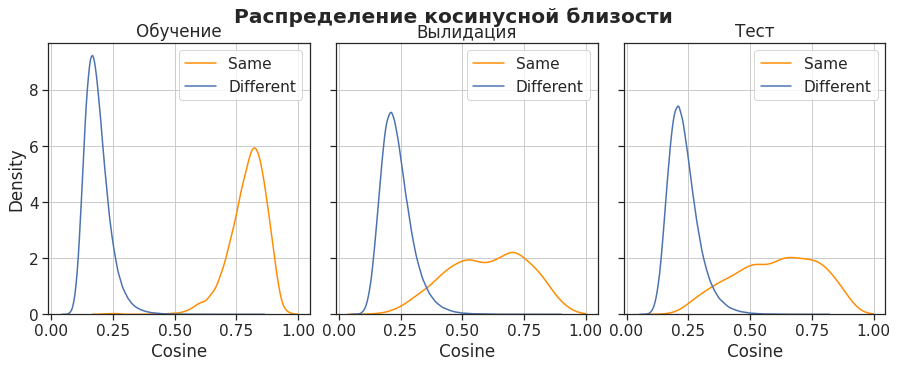

In [56]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5), sharex = True, sharey = True)
plt.subplots_adjust(wspace = 0.1)

same_cosines = [cosine_same_train, cosine_same_val, cosine_same_test]
diff_cosines = [cosine_different_train, cosine_different_val, cosine_different_test]
titles = ['Обучение', 'Вылидация', 'Тест']

for idx, ax in enumerate(ax.flatten()):

    sns.kdeplot(same_cosines[idx], color = 'darkorange', clip = [-1, 1], label = 'Same', ax = ax)
    sns.kdeplot(diff_cosines[idx], clip = [-1, 1], label = 'Different', ax = ax)
    
    ax.legend()
    ax.set(xlabel = 'Cosine', ylabel = 'Density', title = titles[idx])
    ax.grid()
    
plt.suptitle("Распределение косинусной близости", fontweight = 'bold')
plt.show()

## Task 2 (2 points): Identificaton rate metric

When training the model above we used CE loss on val and test set as a measure of performance of our model. But this has a major disadvantage: we can't measure how godd a model would work on unseen faces (which are not present in training, val & test sets)

To address this we can calculate another metric for the model: **identification rate**. This is how it works:

We have two sets of faces: query and distractors. None of the faces from those sets are present in train, val or test sets.

1. calculate cosine similarities between all the faces corresponding to the same people from query dataset. This means if the person has 3 photos in query part: 01.jpg, 02.jpg, 03.jpg, then calculate 3 cosine similarities between every pair of embeddings corresponding to those photos. 
2. calculate cosine similarities between all the faces corresponding to the different people from query dataset. 
3. calculate cosine similarities between all the pairs of embeddings corresponding to query and distractors. This means calculate similarities between pairs (q, d), where q is the embedding that corresponds to a face from query, d — embedding that corresponds to a face from distractors. You'll get |query|*|distractors| similarities.
4. Sum numbers of similarities from 2 and 3 stages. This is a number of false pairs.
5. fix **FPR** (false positive rate). Let it be 0.01 in our case. FPR multiplied by a number of false pairs from the stage 4 is the number of false positives we would allow our model to make. Let's call this number N
6. Sort all the similarities of false pairs by descending order. Get the Nth element from the beginning — that's our **threshold similarity**.
7. Calculate how many positive similarities from stage 1 are equal or more that threshold. Divide this number by whole number of positive similarities from stage 1. This is TPR (true positive rate) — our metric.

This metric can also be expressed as TPR@FPR=0.01. FPR can vary. 

Datasets (query photos, query labels & distructors photos) you can download using the code below:

In [32]:
! curl -L $(yadisk-direct https://disk.yandex.com/d/KN4EEkNKrF_ZXQ) -o celebA_ir.zip
! unzip -qq celebA_ir.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 8978k  100 8978k    0     0  7194k      0  0:00:01  0:00:01 --:--:-- 17.3M


**Task**: implement the TPR@FPR metric. Calculate it for your model and test dataset on FPR=[0.5, 0.2, 0.1, 0.05].

There're some functions pre-defined and some tests given for better understanding. Please don't change the functions prototypes, so that you can use asserts for checking.


In [57]:
from collections import defaultdict

# file with query part annotations: which image belongs to which class
# format: 
#     image_name_1.jpg 2678
#     image_name_2.jpg 2679
f = open('./celebA_ir/celebA_anno_query.csv', 'r')
query_lines = f.readlines()[1:]
f.close()
query_lines = [x.strip().split(',') for x in query_lines]
# plain list of image names from query. Neede to compute embeddings for query
query_img_names = [x[0] for x in query_lines]

# dictionary with info of which images from query belong to which class
# format:
#     {class: [image_1, image_2, ...]}
query_dict = defaultdict(list)
for img_name, img_class in query_lines:
    query_dict[img_class].append(img_name)

# list of distractor images
distractors_img_names = os.listdir('./celebA_ir/celebA_distractors') 

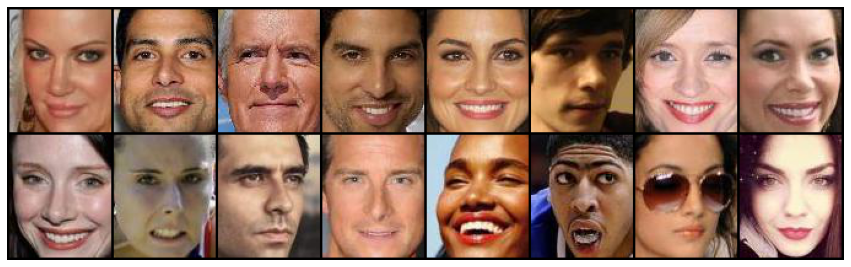

In [58]:
# Посмотрим на изображения из датасета celebA_query

show_imgs('./celebA_ir/celebA_query', 16)

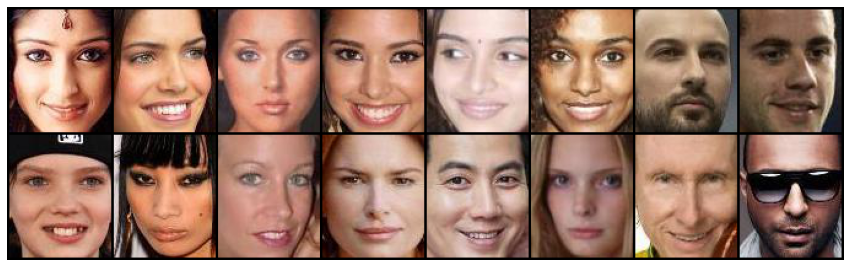

In [59]:
# Посмотрим на изображения из датасета celebA_distractors


show_imgs('./celebA_ir/celebA_distractors', 16)

In [60]:
#  Разметка картинок по person
celebA_ir = pd.read_csv("./celebA_ir/celebA_anno_query.csv", header = None)[1:]
celebA_ir.columns = ['image_name', 'person']
print(len(celebA_ir))
celebA_ir.head()

1222


image_name person
1  001265.jpg     35
2  001430.jpg     35
3  012834.jpg     35
4  041171.jpg     35
5  041823.jpg     35

In [61]:
def compute_embeddings(model, source_path, images_list, tmfs, device = 'cpu'):
    '''
    compute embeddings from the trained model for list of images.
    params:
    model: trained nn model that takes images and outputs embeddings
    source_path : path to folder of images paths
    images_list : list of images paths to compute embeddings for
    tmfs : transform preprocessing list
    device : computing device
    output:
    list: list of model embeddings. Each embedding corresponds to images 
          names from images_list
    '''

    
    model = model.to(device)
    model.eval()    
    embeddings = []

    for image_path in tqdm(images_list):
        image_path = os.path.join(source_path, image_path)
        img = Image.open(image_path)
        img = tmfs(img).to(device)
        
        with torch.no_grad():
            embedding = model.forward(img.unsqueeze(0))
        
        embeddings.append(embedding)

    return torch.cat(embeddings, 0)

def compute_cosine(embedding_a, embedding_b):
    embedding_a = embedding_a.unsqueeze(0)
    embedding_b = embedding_b.unsqueeze(0)

    num = torch.mm(embedding_a, embedding_b.T)
    dist_a = torch.sqrt(torch.mm(embedding_a, embedding_a.T))
    dist_b = torch.sqrt(torch.mm(embedding_b, embedding_b.T))
    cosine = num / (dist_a * dist_b)

    return cosine.item()



In [62]:
tmfs = T.Compose([
    T.ToTensor(),
    T.Resize(340),
    T.CenterCrop((224, 224)),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  
])

device = 'cuda:1'


query_embeddings = compute_embeddings(embedder.to(device), './celebA_ir/celebA_query', query_img_names, tmfs, device = device)
distractors_embeddings = compute_embeddings(embedder.to(device), './celebA_ir/celebA_distractors', distractors_img_names, tmfs, device = device)

100%|███████████████████████████████████████| 2001/2001 [02:35<00:00, 12.89it/s]


In [63]:
def compute_cosine_query_pos(query_dict, query_img_names, query_embeddings):
    '''
    compute cosine similarities between positive pairs from query (stage 1)
    params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in 
                the dataset. Value: images corresponding to that class
    query_img_names: list of images names
    query_embeddings: list of embeddings corresponding to query_img_names
    output:
    list of floats: similarities between embeddings corresponding 
                    to the same people from query list
    '''
    
    query_img_names = np.array(query_img_names)
    
    cosine_dist_list = []
    
    for index_a in tqdm(range(len(query_img_names))):
        
        img_a = query_embeddings[index_a]
        name_a = query_img_names[index_a]
        label_a = [k for k, v in query_dict.items() if name_a in v][0]
        
        for index_b in range(index_a, len(query_img_names)):
            if index_a != index_b:
                
                img_b = query_embeddings[index_b]
                name_b = query_img_names[index_b]
                label_b = [k for k, v in query_dict.items() if name_b in v][0]

                if label_a == label_b:
                    cosine_dist_list.append(compute_cosine(img_a, img_b))
 
    return cosine_dist_list
    

def compute_cosine_query_neg(query_dict, query_img_names, query_embeddings):
    '''
    compute cosine similarities between negative pairs from query (stage 2)
    params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in 
                the dataset. Value: images corresponding to that class
    query_img_names: list of images names
    query_embeddings: list of embeddings corresponding to query_img_names
    output:
    list of floats: similarities between embeddings corresponding 
                    to different people from query list
    '''
    
    query_img_names = np.array(query_img_names)
    cosine_dist_list = []
    
    for index_a in tqdm(range(len(query_img_names))):
        
        img_a = query_embeddings[index_a]
        name_a = query_img_names[index_a]
        label_a = [k for k, v in query_dict.items() if name_a in v][0]
        
        for index_b in range(index_a, len(query_img_names)):
            if index_a != index_b:
                img_b = query_embeddings[index_b]
                name_b = query_img_names[index_b]
                label_b = [k for k, v in query_dict.items() if name_b in v][0]

                if label_a != label_b:
                    cosine_dist_list.append(compute_cosine(img_a, img_b))
 
    return cosine_dist_list


def compute_cosine_query_distractors(query_embeddings, distractors_embeddings):
    '''
    compute cosine similarities between negative pairs from query and distractors
    (stage 3)
    params:
    query_embeddings: list of embeddings corresponding to query_img_names
    distractors_embeddings: list of embeddings corresponding to distractors_img_names
    output:
    list of floats: similarities between pairs of people (q, d), where q is 
                    embedding corresponding to photo from query, d —
                    embedding corresponding to photo from distractors
    '''
    cosine_dist_list = []

    for emb_a in tqdm(query_embeddings):
        for emb_b in distractors_embeddings:
            cosine_dist_list.append(compute_cosine(emb_a, emb_b))
    return cosine_dist_list

In [64]:
cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names,query_embeddings)
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names,query_embeddings)
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings,distractors_embeddings)

100%|███████████████████████████████████████| 1222/1222 [05:13<00:00,  3.90it/s]


Check you code of functions which compute similarities:

In [65]:
test_query_dict = {
    2876: ['1.jpg', '2.jpg', '3.jpg'],
    5674: ['5.jpg'],
    864:  ['9.jpg', '10.jpg'],
}
test_query_img_names = ['1.jpg', '2.jpg', '3.jpg', '5.jpg', '9.jpg', '10.jpg']
test_query_embeddings = [
                    [1.56, 6.45,  -7.68],
                    [-1.1 , 6.11,  -3.0],
                    [-0.06,-0.98,-1.29],
                    [8.56, 1.45,  1.11],
                    [0.7,  1.1,   -7.56],
                    [0.05, 0.9,   -2.56],
                    ]

test_distractors_img_names = ['11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg']

test_distractors_embeddings = [
                    [0.12, -3.23, -5.55],
                    [-1,   -0.01, 1.22],
                    [0.06, -0.23, 1.34],
                    [-6.6, 1.45,  -1.45],
                    [0.89,  1.98, 1.45],
                    ]

test_cosine_query_pos = compute_cosine_query_pos(test_query_dict, np.array(test_query_img_names), 
                                            torch.tensor(test_query_embeddings))
test_cosine_query_neg = compute_cosine_query_neg(test_query_dict, np.array(test_query_img_names), 
                                            torch.tensor(test_query_embeddings))
test_cosine_query_distractors = compute_cosine_query_distractors(torch.tensor(test_query_embeddings), 
                                            torch.tensor(test_distractors_embeddings))

100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 1718.98it/s]


In [66]:
true_cosine_query_pos = [0.8678237233650096, 0.21226104378511604,
                         -0.18355866977496182, 0.9787437979250561]
assert np.allclose(sorted(test_cosine_query_pos), sorted(true_cosine_query_pos)), \
      "A mistake in compute_cosine_query_pos function"

true_cosine_query_neg = [0.15963231223161822, 0.8507997093616965, 0.9272761484302097,
                         -0.0643994061127092, 0.5412660901220571, 0.701307100338029,
                         -0.2372575528216902, 0.6941032794522218, 0.549425446066643,
                         -0.011982733001947084, -0.0466679194884999]
assert np.allclose(sorted(test_cosine_query_neg), sorted(true_cosine_query_neg)), \
      "A mistake in compute_cosine_query_neg function"

true_cosine_query_distractors = [0.3371426578637511, -0.6866465610863652, -0.8456563512871669,
                                 0.14530087113136106, 0.11410510307646118, -0.07265097629002357,
                                 -0.24097699660707042,-0.5851992679925766, 0.4295494455718534,
                                 0.37604478596058194, 0.9909483738948858, -0.5881093317868022,
                                 -0.6829712976642919, 0.07546364489032083, -0.9130970963915521,
                                 -0.17463101988684684, -0.5229363015558941, 0.1399896725311533,
                                 -0.9258034013399499, 0.5295114163723346, 0.7811585442749943,
                                 -0.8208760031249596, -0.9905139680301821, 0.14969764653247228,
                                 -0.40749654525418444, 0.648660814944824, -0.7432584300096284,
                                 -0.9839696492435877, 0.2498741082804709, -0.2661183373780491]
assert np.allclose(sorted(test_cosine_query_distractors), sorted(true_cosine_query_distractors)), \
      "A mistake in compute_cosine_query_distractors function"

Implement the final function: identification rate calculation

In [67]:
def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, 
               fpr=0.1):
    '''
    compute identification rate using precomputer cosine similarities between pairs
    at given fpr
    params:
    cosine_query_pos: cosine similarities between positive pairs from query
    cosine_query_neg: cosine similarities between negative pairs from query
    cosine_query_distractors: cosine similarities between negative pairs 
                              from query and distractors
    fpr: false positive rate at which to compute TPR
    output: 
    float: threshold for given fpr 
    float: TPR at given FPR
    '''
    
    positive = torch.tensor(cosine_query_pos)
    negative = torch.cat((torch.tensor(cosine_query_neg), torch.tensor(cosine_query_distractors)))
    
    N = int(fpr * len(negative))
    threshold = negative.sort(descending = True).values[N]
    identification_rate = sum(positive > threshold) / len(positive)
    return threshold, identification_rate.item()

compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors)

(tensor(0.6884), 0.3157394230365753)

Check yourself:

In [68]:
test_thr = []
test_tpr = []
for fpr in [0.5, 0.3, 0.1]:
    x, y = compute_ir(test_cosine_query_pos, test_cosine_query_neg, 
                    test_cosine_query_distractors, fpr=fpr)
    test_thr.append(x)
    test_tpr.append(y)

In [69]:
true_thr = [-0.011982733001947084, 0.3371426578637511, 0.701307100338029]
assert np.allclose(np.array(test_thr), np.array(true_thr)), "A mistake in computing threshold"

true_tpr = [0.75, 0.5, 0.5]
assert np.allclose(np.array(test_tpr), np.array(true_tpr)), "A mistake in computing tpr"

Finally compute tpr for faces query and distractors dataset and fpr = [0.5, 0.2, 0.1, 0.05]:

In [70]:
for fpr in [0.5, 0.2, 0.1, 0.05]:
    ir = compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, fpr = fpr)
    print("Identification rate(FPR={}): {:.3f}, threshold {:.3f}".format(fpr, ir[1], ir[0]))

Identification rate(FPR=0.5): 0.734, threshold 0.556
Identification rate(FPR=0.2): 0.455, threshold 0.645
Identification rate(FPR=0.1): 0.316, threshold 0.688
Identification rate(FPR=0.05): 0.214, threshold 0.723


In [71]:
fpr = torch.linspace(0, 0.99, 25)

thr, tpr = [], []

for k in tqdm(fpr):
    ir = compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, fpr = k)
    thr.append(ir[0])
    tpr.append(ir[1])

100%|███████████████████████████████████████████| 25/25 [00:16<00:00,  1.50it/s]


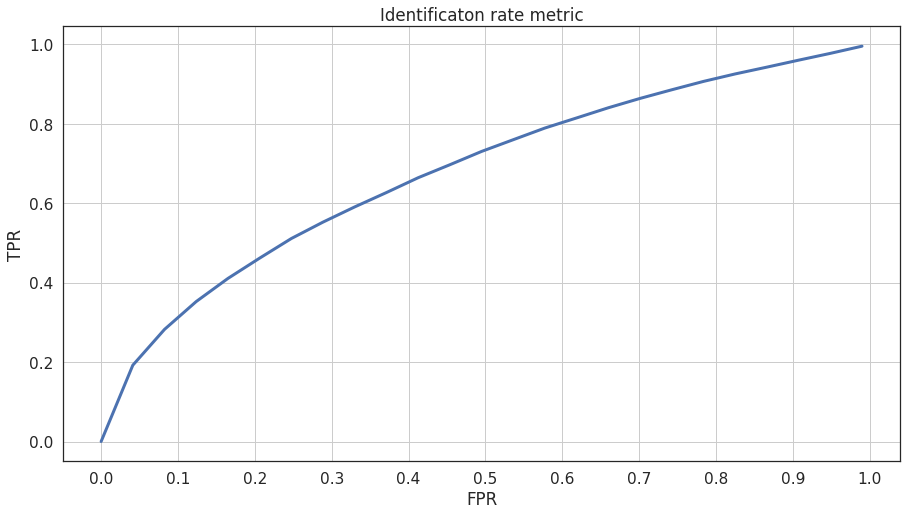

In [72]:
fig = plt.figure(figsize = (15, 8))
sns.set(style = 'white', font_scale = 1.4)

sns.lineplot(x = fpr, y = tpr, lw = 3)
plt.title("Identificaton rate metric")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.grid()
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.2, 0.2))
plt.show()

## Task 3 (4 points): Loss functions

Building a network on task 1 we used an ordinary CE loss. But there are many more variants of loss functions that can be used to train neural network. We will discuss two of them, which are the most popular. More examples of losses for face recognition and their performance reviews you can find in this paper: https://arxiv.org/pdf/1901.05903.pdf

### TripletLoss (2 points)

This is another kind of loss which does not require a model to have last classification layer — it works directly with embeddings. It requires by design to make embeddings of one person be close on embeddings space and embeddings of different people be far away from each other. 

This loss has an advantage over CE-like losses: it does not rely on number of classes in dataset. If we have new faces of new people in a dataset, we won't need to completely retrain the network, we could just fine-tune the trained network on new photos.


**How TripletLoss works**:

Here the architecture of neural network will be slightly different than it was when we used CE loss: it won't have the last classification layer. The last layer of NN will output embeddings of the given photo. 

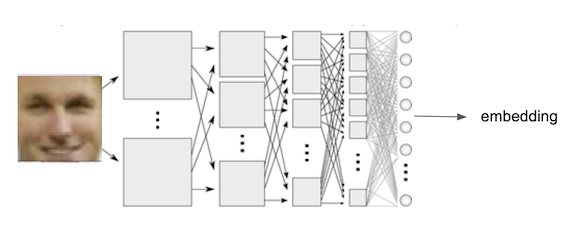

The TripletLoss function works directly with these embeddings. The idea of it is to make embeddings of the same people more close, compact in the embedding space, and the embeddings of the different people be more separate. There's a formula for the loss:

$$L(e, p, n) = max\{d(a, p) - d(a, n) + margin, 0\},$$

where 
- $e$ is embedding of a photo (output of a model)
- $p$ is a positive embedding for the photo (embedding that we want $e$ be close to)
- $n$ is a negative embedding for the photo (embedding that we want $e$ be far from)
- $d(x, y)$ is a distance measure between embeddings 
- margin — a positive margin to further boost the difference between $d(a, p)$ and $d(a, n)$

**All the embeddings $e$, $p$ and $n$ must be normalized before passing them to the loss**.

In our case for the given photo $E$ and it's embedding $e$ positive embedding $p$ must be an embedding of the photo of the same person and embedding $n$ must be an ambedding of the photo of the different person.

This emplementation of TripletLoss for PyTorch can be found [here](https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss). There are different variants of TripletLoss which can also boost performance and which you can implement by yourself, if you want:
- use more that 1 sample of $p$ and $n$ for one embedding $e$ 
- use special kinds of negatives: e.g. the negatives that are the most close to e (to boost them be further away from e)


**More to read about TripletLoss**:

The idea of TripletLoss: https://en.wikipedia.org/wiki/Triplet_loss

PyTorch implementation of TripletLoss: https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss

**Task**: implement a model and train it with TripletLoss. Play with margin parameter to achieve better results. Again, you might use whatever architecture you prefer, including ImageNet pre-trained networks. Do not use pre-trained networks on any other dataset.

Which loss among which you have tried is the best?

**To get the full mark for this task you need to train a model using  TripletLoss correctly at least for one value of margin and achieve >=70% acc on test set.** 
As we don't have a classification layer in our network, we need a custom procedure for accuracy calculation. You can use one of the following procedures:
- calculate accuracy on val and test sets using KNN with embeddings from training set as training points. (easy way)
- compute mean embeddings for every class from training set and use them as reference embeddings. Then for every embeddings from val and test sets calculate cosine similarities be 

**Hints**:
- think of what the distance function $d$ should be in our case: training a model we want it to output embeddings which can be compared using cosine similarity function. Pay attention to that cosine similarity is not a distance measure — the more cosine distance, the closer embeddings are. Think how you can put cosine distance into TripletLoss function.
- to train model using this loss you'll need to rewrite the Dataset class so it gives you not the random image and its label, but the image, positive images and negative images for this image;
- don't forget to normalize embeddings for the loss! You may even do that by adding batchnorm/layernorm to the last layer of your network

In [73]:
from torch.utils.data import WeightedRandomSampler # Выбирает элементы с заданными вероятностями 

# Создадим сэмплер, который будет чаще подавть в батчи картинки меньшего класса


f = open('./celebA_train_500/celebA_anno.txt', 'r') 
annotation = f.readlines()
f.close()

f = open('./celebA_train_500/celebA_train_split.txt', 'r')
split = f.readlines()
f.close()

classes = torch.tensor([int(x[:-1].split(' ')[1]) for x in annotation])
split = torch.tensor([int(x[:-1].split(' ')[1]) for x in split])

indexes = torch.where(split == 0) # Выбираем только элементы из обучающей выборки
classes = classes[indexes]

weights = []

for c in classes:
    samples = torch.where(classes == c)[0]
    rate = len(samples) / len(classes)
    weights.append(1 - rate)
    
    
weighted_sampler = WeightedRandomSampler(weights, num_samples = len(weights))

In [74]:
class TripletDataset(Dataset):
    def __init__(self,dataset_type, source, annotation, split, tmfs):

        self.dataset_type = dataset_type
        self.source = source
        self.tmfs = tmfs

        vocab = {
            'train' : 0,
            'val' : 1,
            'test' : 2}

        # Чтение имён картинок и их меток
        with open(annotation, "r") as f:
            self.annotation = f.readlines()
        self.annotation = np.array([x[:-1].split(' ') for x in self.annotation])
        self.names, self.labels = self.annotation[:, 0], self.annotation[:, 1].astype(int)

        # Чтение файла split
        with open(split_info, "r") as f:
            self.split = f.readlines()
        self.split = np.array([x[:-1].split(' ') for x in self.split])
        self.split = self.split[:, 1].astype(int)

        # Предобработка имён картинок и их меток
        self.samples = self.names[self.split == vocab[self.dataset_type]]
        self.labels = self.labels[self.split == vocab[self.dataset_type]]
        self.labels = torch.from_numpy(self.labels)
                
    def load(self, img):

        img = Image.open(os.path.join(self.source, img))
        img = self.tmfs(img)

        return img

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        if self.dataset_type in ['train', 'val']:
            same_class_index = torch.where(self.labels == self.labels[index])[0] # Выведем индексы всех элементов того же класса
            diff_class_index = torch.where(self.labels != self.labels[index])[0] # Выведем индексы всех элементов принадлежащие другому класса
            
            try:
                anchor_index, positive_index = np.random.choice(same_class_index, 2, replace = False) # выбираем два индекса
                positive = self.load(self.samples[positive_index])

            except: # если двух индексов нет, то просто отзеркалим картинку
                anchor_index, positive_index = np.random.choice(same_class_index, 2, replace = True)
                positive = self.load(self.samples[positive_index])
                positive = torchvision.transforms.functional.hflip(positive)

            negative_index = np.random.choice(diff_class_index, 1)[0]
            anchor = self.load(self.samples[anchor_index])
            negative = self.load(self.samples[negative_index])
            
            lable_anchor = self.labels[anchor_index]
            lable_positive = self.labels[positive_index]
            lable_negative = self.labels[negative_index]

            return anchor, positive, negative, lable_anchor, lable_positive, lable_negative
        
        elif self.dataset_type == 'test':
            samples = self.samples[index]
            samples = self.load(samples)
            labels = self.labels[index]
            
            return samples, labels
        
        else:
            raise ValueError("Для значения dataset_type выберете из ['train', 'val', 'test']")
            
custom_transforms = T.Compose([
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

source = './celebA_train_500/celebA_prep/'
annot_info = './celebA_train_500/celebA_anno.txt'
split_info = './celebA_train_500/celebA_train_split.txt'

triplet_train = TripletDataset('train', source, annot_info, split_info, custom_transforms)
triplet_val = TripletDataset('val', source, annot_info, split_info, custom_transforms)
triplet_test = TripletDataset('test', source, annot_info, split_info, custom_transforms)

batch_size = 46
train_loader = torch.utils.data.DataLoader(triplet_train, batch_size = batch_size, num_workers = 16, sampler = weighted_sampler)
val_loader = torch.utils.data.DataLoader(triplet_val, batch_size = batch_size, shuffle = True, num_workers = 16)
test_loader = torch.utils.data.DataLoader(triplet_test, batch_size = batch_size, shuffle = False, num_workers = 16)

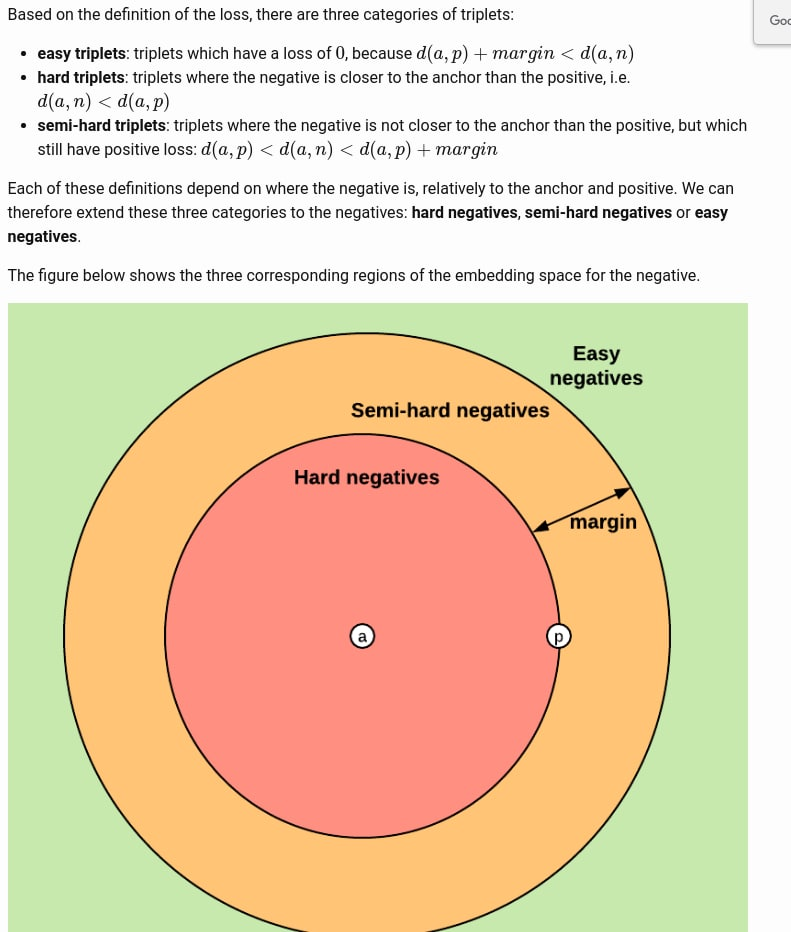

In [84]:
def pairwise_cosine(x, y = None, zero_diag = True):
    '''
    Расчитать косинусную близость попарно
    
    '''
    
    if y is None:
        y = x.clone()
    x_norm = torch.linalg.norm(x, ord = 2, dim = 1)
    x = x.div(x_norm.unsqueeze(1))
    y_norm = torch.linalg.norm(y, ord = 2, dim = 1)
    y = y.div(y_norm.unsqueeze(1))
    cosine = x @ y.T
    if zero_diag:
        cosine.fill_diagonal_(0)
    cosine = cosine.type(torch.FloatTensor)
        
    return cosine

In [85]:
def compute_cosine_distance(x, y = None, zero_diag = False):
        if y is None:
            y = x.clone()
            zero_diag = True
            
        x_norm = torch.linalg.norm(x, ord = 2, dim = 1)
        x = x / x_norm.unsqueeze(1)

        y_norm = torch.linalg.norm(y, ord = 2, dim = 1)
        y = y / y_norm.unsqueeze(1)

        similarity = x @ y.T
        distance = (1 - similarity)

        if zero_diag:
            distance.fill_diagonal_(0)

        return distance
    
def masked_minimum_torch(data, mask, dim = 1):
    axis_maximus, _ = torch.max(data, dim, keepdim = True)
    
    masked_minimus = (
        torch.min(
        torch.multiply(data - axis_maximus, mask), dim, keepdim = True
        )[0] 
        + axis_maximus
    )

    return masked_minimus

def masked_maximum_torch(data, mask, dim = 1):
    axis_minimus, _ = torch.min(data, dim, keepdim = True)
    masked_maximus = (
        torch.max(
            torch.multiply(data - axis_minimus, mask), dim, keepdim = True
        )[0]
        + axis_minimus
        )

    return masked_maximus

class TripletLossHard(nn.Module):
    def __init__(self, margin = 1.0, soft = None, device = 'cpu'):
        super().__init__()
        self.margin = margin
        self.device = device
        self.soft = soft
        
    def forward(self, embeddings, labels):
        batch_size = labels.size(0)
        
        dist = 1 - pairwise_cosine(embeddings, zero_diag = False).to(device)
        
        mask_positive = torch.eq(labels.unsqueeze(0), labels.unsqueeze(1)).float()
        mask_negative = torch.logical_not(mask_positive).float()

        hard_negative = masked_minimum_torch(dist, mask_negative)
    
        mask_positive = mask_positive - torch.eye(batch_size, device = self.device)
        hard_positive = masked_maximum_torch(dist, mask_positive)
    
        if self.soft:
            triplet_loss = torch.log1p(torch.exp(hard_positive - hard_negative))
        else:
            triplet_loss = F.relu(hard_positive - hard_negative + self.margin)
        
        triplet_loss = torch.mean(triplet_loss)
        
        return triplet_loss


class TripletLossSemiHard(nn.Module):
    def __init__(self, margin = 1.0, device = 'cpu'):
        super().__init__()
        self.margin = margin
        self.device = device
        
    def forward(self, embeddings, labels):
        pdist_matrix = 1 - pairwise_cosine(embeddings, zero_diag = False).to(device)

        adjacency = torch.eq(labels.unsqueeze(0), labels.unsqueeze(1))
        adjacency_not = torch.logical_not(adjacency).float()

        batch_size = labels.size(0)

        pdist_matrix_tile = torch.tile(pdist_matrix, [batch_size, 1])

        mask = torch.logical_and(
            torch.tile(adjacency_not, [batch_size, 1]),
            torch.greater(
                pdist_matrix_tile, pdist_matrix.T.reshape(-1, 1))
            ).float()

        mask_final = torch.greater(
            torch.sum(mask, dim = 1, keepdim = True),
            0.0).reshape(batch_size, batch_size).T

        negative_outside = masked_minimum_torch(pdist_matrix_tile, mask)
        negative_outside = negative_outside.reshape(batch_size, batch_size).T

        negative_inside = masked_maximum_torch(pdist_matrix, adjacency_not)
        negative_inside = torch.tile(negative_inside, [1, batch_size])

        semihard_negative = torch.where(mask_final, negative_outside, negative_inside)

        loss_mat = torch.add(self.margin, pdist_matrix - semihard_negative)

        mask_positive = adjacency.float() - torch.eye(batch_size, device = self.device)

        num_positives = torch.sum(mask_positive)


        triplet_loss = torch.true_divide(
            torch.sum(
                torch.max(torch.multiply(loss_mat, mask_positive), 0)[0]
            ),
            num_positives,
        )

        return triplet_loss

In [86]:
import torch.nn.functional as F

def compute_mean_class_embedding(embeddings, labels):
    '''
    Функция вычисляющая средний эмбеддинг класса
    '''

    mean_embeddings = []
    mean_embeddings_class = []
    
    for label in labels.unique():
        mask = (labels == label)
        class_embeddings = embeddings[mask]
        mean_embeddings.append(class_embeddings.mean(0))
        mean_embeddings_class.append(label)

    mean_embeddings = torch.stack(mean_embeddings)
    mean_embeddings_class = torch.tensor(mean_embeddings_class)
        
    return mean_embeddings, mean_embeddings_class

def compute_embeddings(model, loader, device, dtype):
    '''
    Вычисление эмбеддингов
    '''
    
    model.eval()
    embeddings = []
    labels = []

    if dtype == 'triplet':
        for anc, pos, neg, lanc, lpos, lneg in tqdm(loader, desc = 'Вычисление эмбеддингов'):
            batch_x = torch.cat((anc, pos, neg), dim = 0).to(device)
            batch_y = torch.cat((lanc, lpos, lneg), dim = 0).to(device) 

            with torch.no_grad():
                embeddings.append(model.forward(batch_x))
                labels.append(batch_y)
    
    elif dtype == 'batch':
        for batch_x, batch_y in tqdm(loader, desc = 'Вычисление эмбеддингов'):
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            
            with torch.no_grad():
                embeddings.append(model.forward(batch_x))
                labels.append(batch_y)

    return torch.cat(embeddings, dim = 0), torch.cat(labels)

def predict_class(embeddings, reference, classes):
    
    distance = compute_cosine_distance(embeddings, reference, zero_diag = False)
    nearest_index = torch.argmin(distance, dim = 1)
    predicted_class = classes[nearest_index]

    return predicted_class
    

In [87]:
def fit(model, tr_loader, val_loader, criterion, optimizer, n_epochs, scheduler = None):
        
    history = {
        'train_loss' : [],
        'val_loss' : [],
        'train_accuracy' : [],
        'val_accuracy' : [],
    }
    
    for epoch in range(n_epochs):
        
        model.eval()
        
        tr_embeddings, tr_labels = compute_embeddings(model, tr_loader, device, dtype = 'triplet')
        reference_emb, reference_class = compute_mean_class_embedding(tr_embeddings, tr_labels)
        
        
        # Переложим эмбеддинги на CPU
        tr_embeddings = tr_embeddings.cpu()
        tr_labels = tr_labels.cpu()
        reference_emb = reference_emb.cpu()
        reference_class = reference_class.cpu()
        
        
        model.train()
        tr_loss = []
        tr_accuracy = []
       
        for idx, (anc, pos, neg, lanc, lpos, lneg) in enumerate(tqdm(tr_loader, desc = 'Обучение...')):
            
            batch_x = torch.cat((anc, pos, neg), dim = 0).to(device)
            batch_y = torch.cat((lanc, lpos, lneg), dim = 0).to(device)
            
            optimizer.zero_grad()
  
            embeddings = model.forward(batch_x)
            
        

            loss = criterion(embeddings, batch_y)
            
            loss.backward()
            optimizer.step()
            
            predicted_class = predict_class(embeddings.detach().cpu(), reference_emb, reference_class).to(device)
            correct = torch.sum(predicted_class == batch_y).item()
            
            tr_loss.append(loss.item())
            tr_accuracy.append(correct / len(batch_y))
                
        tr_loss = np.mean(tr_loss)
        tr_accuracy = np.mean(tr_accuracy)
                
        # Логгирование
        history['train_loss'].append(tr_loss)
        history['train_accuracy'].append(tr_accuracy)
        
        if scheduler is not None:
            scheduler.step()
            
            
        # Inference
        model.eval()
        val_loss = []
        val_accuracy = []
        
        for idx, (anc, pos, neg, lanc, lpos, lneg) in enumerate(tqdm(val_loader, desc = 'Валидация...')):
            batch_x = torch.cat((anc, pos, neg), dim = 0).to(device)            
            batch_y = torch.cat((lanc, lpos, lneg), dim = 0).to(device)

            with torch.no_grad():
                embeddings = model.forward(batch_x)
                loss = criterion(embeddings, batch_y)
                predicted_class = predict_class(embeddings.cpu(), reference_emb, reference_class).to(device)
                correct = torch.sum(predicted_class == batch_y).item()
                val_loss.append(loss.item())
                val_accuracy.append(correct / len(batch_y))
                        
        val_loss = np.mean(val_loss)
        val_accuracy = np.mean(val_accuracy)
        
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)
               
        # Очистить кэш  
        garbage = [tr_embeddings, tr_labels, reference_emb, 
                   reference_class, batch_x, batch_y]
        
        clear_memory(garbage)
        clear_output(wait = True)
        
        tensorboard(history, n_epochs)
        
        # Сохранение чекпоинта
        create_checkpoint(model, optimizer, epoch, name = 'inception-resnet-v2_triplet')

In [89]:
class L2Norm1d(nn.Module):
    def __init__(self, p = 2.):
        super().__init__()
        self.p = p
        
    def forward(self, x):
        return F.normalize(x, p = self.p, dim = 1)


embedding_size = 512


inception_resnet_v2 = timm.create_model('inception_resnet_v2', pretrained=True, num_classes=0)
inception_resnet_v2.classif = nn.Sequential(
    nn.Linear(1536, embedding_size), # Without activation model performs better
    nn.BatchNorm1d(embedding_size),
    nn.ReLU(inplace = True),
    L2Norm1d()
)


# Посчитаем число параметров модели inception_resnet_v2
sum([p.numel() for p in inception_resnet_v2.parameters() if p.requires_grad])

55094432

In [88]:
class LossScheduler():
    def __init__(self, miners):
        self.miners = miners
        
    def __call__(self, embeddings, labels):

        semihard = self.miners[0][1](embeddings, labels)
        hard = self.miners[1][1](embeddings, labels)
        
        return semihard + hard

In [90]:
import gc

def clear_memory(garbage = list()):
    '''
    Очистить память: перенести объект на процессор, если это возможно,
    удалить, очистить кеш GPU и вызвать gc.collect()
    '''
    
    for item in garbage:
        try:
            item.cpu()
        except:
            pass
        
        del item
    
    torch.cuda.empty_cache()
    gc.collect()

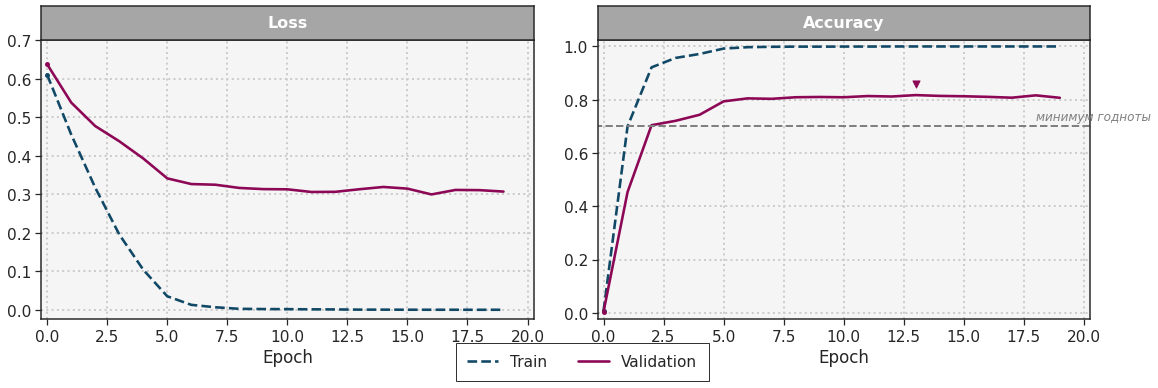

In [93]:
import sys
import torchvision

clear_memory()

device =  'cuda:2'
model = inception_resnet_v2.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4)


miners = ([
    ('semihard', TripletLossSemiHard(margin = 0.4, device = device)),
    ('hard', TripletLossHard(margin = 0.4, device = device))])

n_epochs = 20
criterion = LossScheduler(miners)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [n_epochs//4, n_epochs//3, n_epochs//2], gamma = 0.4)

fit(model, train_loader, val_loader, criterion, optimizer, n_epochs, scheduler)

In [94]:
embeddings, labels = compute_embeddings(model.eval(), val_loader, device, 'triplet')

Вычисление эмбеддингов: 100%|███████████████████| 41/41 [00:27<00:00,  1.51it/s]


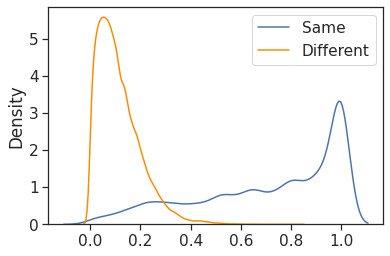

In [95]:
labels = labels.cpu()

distance = compute_cosine_distance(embeddings, zero_diag = True).cpu()
eye = torch.eye(labels.size(0)).byte() ^ 1
positive_mask = torch.triu(((labels.unsqueeze(0) == labels.unsqueeze(1)) * eye).bool())
negative_mask = torch.triu(((labels.unsqueeze(0) != labels.unsqueeze(1)) * eye).bool())

count = 100_000

sns.kdeplot(1 - distance[positive_mask][:count], label = 'Same')
sns.kdeplot(1 - distance[negative_mask][:count], color = 'darkorange', label = 'Different')
plt.legend()

In [96]:
def compute_ir(positive, negative, fpr=0.4):


    N = int(fpr * len(negative))
    threshold = negative.sort(descending = True).values[N]
    identification_rate = sum(positive > threshold) / len(positive)
    
    return threshold, identification_rate.item()

compute_ir(1 - distance[positive_mask][:count], 1 - distance[negative_mask][:count], fpr = 0.05)

(tensor(0.2772), 0.8880306482315063)

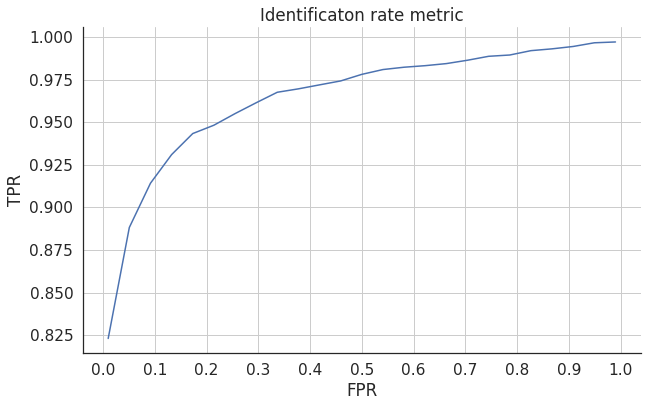

In [99]:
tpr = []

bins = np.linspace(0.01, 0.99, 25)

for i in bins:
    x, y = compute_ir(1 - distance[positive_mask][:count], 1 - distance[negative_mask][:count], fpr = i)
    
    thr.append(x)
    tpr.append(y)

fig = plt.figure(figsize = (10, 6))
sns.set(style = 'white', font_scale = 1.4)

sns.lineplot(x = bins, y = tpr)

plt.title("Identificaton rate metric")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xticks(np.arange(0, 1.1, 0.1))
plt.grid()
sns.despine()


In [100]:
model.eval()
tr_embeddings, tr_labels = compute_embeddings(model, train_loader, device, 'triplet') 
mean_embeddings, mean_embeddings_labels = compute_mean_class_embedding(tr_embeddings, tr_labels)

Вычисление эмбеддингов: 100%|█████████████████| 186/186 [01:54<00:00,  1.63it/s]


In [101]:
def evaluate(model, loader, mean_embeddings, return_res = False, device = 'cpu'):
    model.eval()
    model = model.to(device)
    pred = []
    true = []
        
    for batch_x, batch_y in loader:
        batch = batch_x.to(device)
        labels = batch_y.to(device)

        with torch.no_grad():

            embeddings = model.forward(batch)
            predicted_class = predict_class(embeddings, mean_embeddings, mean_embeddings_labels)
            pred.append(predicted_class)
            true.append(labels)
    
    pred = torch.cat(pred).to(device)
    true = torch.cat(true).to(device)
            
    accuracy = torch.sum(pred == true) / len(true)
    
    return accuracy
        
accuracy = evaluate(model, test_loader, mean_embeddings.to('cpu'), mean_embeddings_labels.to('cpu'), device = 'cpu')
print("Тестовые данные: accuracy {:.2f}".format(accuracy * 100))

Тестовые данные: accuracy 80.37


### ArcFace Loss (Additive Angular Margin Loss) (2 points)

This loss is somewhat "SOTA" for face recognition systems (somewhat — because actually different variants of losses and their combinations may be the best for different network architectures). This loss inherits idea from CE loss but further develops it to achieve better embeddings distribution on a sphere. It introduces some geodesic constraints to enhance intra-class compactness and inter-class discrepancy.



**How ArcFace loss works**:

This loss is a variation of a standard SoftMax CE loss, which enforces embeddings of different classes (people) be further away: have a more sparse representation of embeddings in embedding space, enforce more evident gap between the nearest classes.

The standard SoftMax CE loss for classification task is presented as follows:

$$L_{CE} = \frac{-1}{N}\sum_1^N \frac{e^{W_{y_i}^{T}x_i + b_{y_i}}}{\sum^n_{j=1}e^{W_j^Tx_i+b_j}},$$

where:
- $x_i \in \mathbb{R^d}$ denotes the deep feature of the $i$-th sample, belonging to the $y_i$-th class;
- $W_j \in \mathbb{R^d}$ denotes the j-th column of the weight;
- $W \in \mathbb{R^d}$ and $b_j \in \mathbb{R^d}$ is the bias term;
- $N$ — batch size;
- $n$ — class number.

It appears, that, though this loss works well, it does not explicitly optimise the feature embedding to enforce higher similarity for intra- class samples and diversity for inter-class samples, which results in a performance gap for deep face recognition under large intra-class appearance variations.

Let's do some work on this loss formula:
- fix the bias $b_j=0$;
- normalize weight ||$W_j$|| = 1;
- normalize embedding ||$x_i$|| = 1 and re-scale it to s (s is a hyperparameter)

The normalisation step on embeddings and weights makes the predictions only depend on the angle between the embedding and the weight. The learned embeddings fare thus distributed on a hypersphere with a radius of s.

So we get the following loss function now:

$$L = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos\Theta_{y_i}}}{e^{s\ cos\Theta_{y_i}} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

Final step: let's add an additive angular margin penalty $m$ between $x_i$ and $W_{y_i}$ to simultaneously enhance the intra-class compactness and inter-class discrepancy:

$$L_{ArcFace} = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos(\Theta_{y_i} + m)}}{e^{s\ cos(\Theta_{y_i} + m)} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

SO this is an ArcFace loss. It has 2 hyperparameters: s and m.

The original paper to read about ArcFace more precisely: https://arxiv.org/pdf/1801.07698.pdf

The original repo, where you can find a code sample: https://github.com/deepinsight/insightface

**Task**: implement a model and train it with ArcFace loss. Play with ArcFace loss parameters and see if you can beat a model with CE loss. Again, you might use whatever architecture you prefer, including ImageNet pre-trained networks. Do not use pre-trained networks on any other dataset.

**To get the full mark for this task you need to train a model using TripletLoss correctly at least for one value of margin and achieve >=70% acc on test set.**

In [102]:
# Basic transforms
transform = T.Compose([
        T.ToTensor(),
        T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Augmentation
aug = T.Compose([
        T.ToTensor(),
        T.RandomHorizontalFlip(0.5),
        T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


train_data = celebADataset('train', transform, aug)
val_data = celebADataset('val', transform, None)
test_data = celebADataset('test', transform, None)

# choose your own batch_size
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers = 16, pin_memory = True, sampler = weighted_sampler)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers = 16, pin_memory = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers = 16, pin_memory = True)

In [103]:
def fit(model, tr_loader, val_loader, criterion, optimizer, loss_optimizer, n_epochs, scheduler = None):
        
    history = {
        'train_loss' : [],
        'val_loss' : [],
        'train_accuracy' : [],
        'val_accuracy' : [],
    }
    
    for epoch in range(n_epochs):
        
        model.eval()
        
        tr_embeddings, tr_labels = compute_embeddings(model, tr_loader, device, dtype = 'batch')
        reference_emb, reference_class = compute_mean_class_embedding(tr_embeddings, tr_labels)
        
        
        # Перенос эмбеддингов на CPU
        tr_embeddings = tr_embeddings.cpu()
        tr_labels = tr_labels.cpu()
        reference_emb = reference_emb.cpu()
        reference_class = reference_class.cpu()
        
        
        model.train()
        tr_loss = []
        tr_accuracy = []
       
        for idx, batch in enumerate(tqdm(tr_loader, desc = 'Training')):
            batch_x = batch['image'].to(device)
            batch_y = batch['label'].to(device)
            optimizer.zero_grad()
            loss_optimizer.zero_grad()
            
            
            embeddings = model.forward(batch_x)
            loss = criterion(embeddings, batch_y)
            loss.backward()
            optimizer.step()
            loss_optimizer.step()
            predicted_class = predict_class(embeddings.detach().cpu(), reference_emb, reference_class).to(device)
            correct = torch.sum(predicted_class == batch_y).item()
            tr_loss.append(loss.item())
            tr_accuracy.append(correct / len(batch_y))
                
        tr_loss = np.mean(tr_loss)
        tr_accuracy = np.mean(tr_accuracy)
                
        # Логирование
        history['train_loss'].append(tr_loss)
        history['train_accuracy'].append(tr_accuracy)
        
        if scheduler is not None:
            scheduler.step()
            
            
        # Inference
        model.eval()
        val_loss = []
        val_accuracy = []
        
        for idx, batch in enumerate(tqdm(val_loader, desc = 'Validation')):
            batch_x = batch['image'].to(device)
            batch_y = batch['label'].to(device)

            with torch.no_grad():
                embeddings = model.forward(batch_x)
                loss = criterion(embeddings, batch_y)
                predicted_class = predict_class(embeddings.cpu(), reference_emb, reference_class).to(device)
                correct = torch.sum(predicted_class == batch_y).item()
                val_loss.append(loss.item())
                val_accuracy.append(correct / len(batch_y))
                        
        val_loss = np.mean(val_loss)
        val_accuracy = np.mean(val_accuracy)
        
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)
               
        # Очистка кэша  
        garbage = [tr_embeddings, tr_labels, reference_emb, 
                   reference_class, batch_x, batch_y]
        
        clear_memory(garbage)
        clear_output(wait = True)

        tensorboard(history, n_epochs)
        
        # Сохранение чекпоинта
        create_checkpoint(model, optimizer, epoch, name = 'inception-resnet-v2_arcface')
        

In [104]:
class L2Norm1d(nn.Module):
    def __init__(self, p = 2.):
        super().__init__()
        self.p = p
        
    def forward(self, x):
        return F.normalize(x, p = self.p, dim = 1)


embedding_size = 512


inception_resnet_v2 = timm.create_model('inception_resnet_v2', pretrained=True, num_classes=0)
inception_resnet_v2.classif = nn.Sequential(
    nn.Linear(1536, embedding_size), # Without activation model performs better
    nn.BatchNorm1d(embedding_size),
    nn.ReLU(inplace = True),
    L2Norm1d()
)


# Посчитаем число параметров модели inception_resnet_v2
sum([p.numel() for p in inception_resnet_v2.parameters() if p.requires_grad])

55094432

In [106]:
def compute_embeddings(model, loader, device, dtype):
    '''Computes embeddings'''
    
    model.eval()
    embeddings = []
    labels = []

    if dtype == 'triplet':
        for anc, pos, neg, lanc, lpos, lneg in tqdm(loader, desc = 'Computing embeddings'):

            batch_x = torch.cat((
                anc, pos, neg
            ), dim = 0).to(device)

            batch_y = torch.cat((
                lanc, lpos, lneg
            ), dim = 0).to(device) 

            with torch.no_grad():
                embeddings.append(model.forward(batch_x))
                labels.append(batch_y)
    
    elif dtype == 'batch':
        for batch in tqdm(loader, desc = 'Computing embeddings'):
            batch_x = batch['image'].to(device)
            batch_y = batch['label'].to(device)
            
            with torch.no_grad():
                embeddings.append(model.forward(batch_x))
                labels.append(batch_y)

    return torch.cat(embeddings, dim = 0), torch.cat(labels)

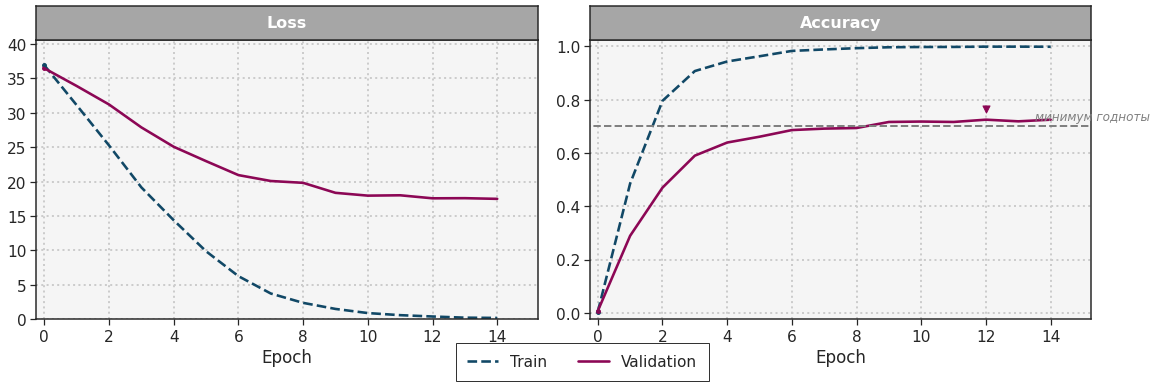

In [107]:
device = 'cuda:2'
model = inception_resnet_v2.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4)
criterion = ArcFaceLoss(500, embedding_size, margin=28.6, scale=64).to(device)
criterion_optimizer = torch.optim.Adam(criterion.parameters(), lr = 3e-4)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95)

n_epochs = 15

fit(model, train_loader, val_loader, criterion, optimizer, criterion_optimizer, n_epochs, scheduler = scheduler)

In [111]:
model.eval()
tr_embeddings, tr_labels = compute_embeddings(model, train_loader, device, dtype = 'batch') 
mean_embeddings, mean_embeddings_labels = compute_mean_class_embedding(tr_embeddings, tr_labels)

Computing embeddings: 100%|█████████████████████| 67/67 [00:39<00:00,  1.71it/s]


In [116]:
def evaluate(model, loader, mean_embeddings, return_res = False, device = 'cpu'):
    model.eval()
    pred = []
    true = []
    
    for batch in loader:
        
        batch_x = batch['image'].to(device)
        batch_y = batch['label'].to(device)

        with torch.no_grad():

            embeddings = model.forward(batch_x)
            predicted_class = predict_class(embeddings, mean_embeddings, mean_embeddings_labels).to(device)
            pred.append(predicted_class)
            true.append(batch_y)
    
    pred = torch.cat(pred)
    true = torch.cat(true)
            
    accuracy = torch.sum(pred == true) / len(true)
    
    return accuracy.cpu()
        
accuracy = evaluate(model.cpu(), test_loader, mean_embeddings.cpu(), mean_embeddings_labels.cpu(), device = 'cpu')
print("Тестовая выборка accuracy {:.2f}".format(accuracy * 100))

Тестовая выборка accuracy 73.00


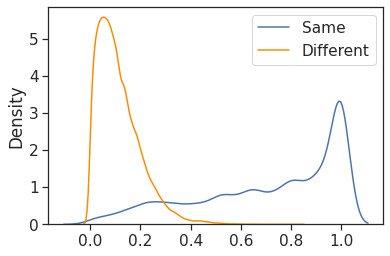

In [121]:
labels = labels.cpu()

distance = compute_cosine_distance(embeddings, zero_diag = True).cpu()
eye = torch.eye(labels.size(0)).byte() ^ 1
positive_mask = torch.triu(((labels.unsqueeze(0) == labels.unsqueeze(1)) * eye).bool())
negative_mask = torch.triu(((labels.unsqueeze(0) != labels.unsqueeze(1)) * eye).bool())

count = 100_000

sns.kdeplot(1 - distance[positive_mask][:count], label = 'Same')
sns.kdeplot(1 - distance[negative_mask][:count], color = 'darkorange', label = 'Different')
plt.legend()